In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
CaseName_Base = 'RTS24_mod1'

Folder_A = 'A.The_full_year_MILP'
Folder_B = 'B.Operation_cost'
Folder_D = 'D.Representative_days_based_on_RES_and_Demand'
Folder_E = 'E.Representative_days_based_on_Line_Benefits_OptModel'
Folder_K = 'K.Investments_per_hour'
Folder_L = 'L.Cont_Investments_per_hour'

Folder_JB = 'J.Full_year_operational_cost\\Results\\B.'
Folder_JD = 'J.Full_year_operational_cost\\Results\\D.'
Folder_JE = 'J.Full_year_operational_cost\\Results\\E.'
Folder_JK = 'J.Full_year_operational_cost\\Results\\K.'
Folder_JL = 'J.Full_year_operational_cost\\Results\\L.'

Folder_JB = 'J.Full_year_operational_cost\\Results\\B.Operation_cost'
Folder_JD = 'J.Full_year_operational_cost\\Results\\D.Representative_days_based_on_RES_and_Demand'
Folder_JE = 'J.Full_year_operational_cost\\Results\\E.Representative_days_based_on_Line_Benefits_OptModel'
Folder_JK = 'J.Full_year_operational_cost\\Results\\K.Investments_per_hour'
Folder_JL = 'J.Full_year_operational_cost\\Results\\L.Cont_Investments_per_hour'

DirName  = os.getcwd()
_path_0 = os.path.join(DirName, CaseName_Base)
category_dict = {Folder_A: "FYMILP",
                 Folder_B: "OPC",
                 Folder_D: "R&D",
                 Folder_E: "OPT_LB",
                 Folder_K: "HI",
                 Folder_L: "CHI",
                 Folder_JB: "OPC_fy",
                 Folder_JD: "R&D_fy",
                 Folder_JE: "OPT_LB_fy",
                 Folder_JK: "HI_fy",
                 Folder_JL: "CHI_fy"
                }

In [17]:
def LoadingData(dir, folder,result, case, ncluster, cm):
    if folder == 'A.The_full_year_MILP': 
        df = pd.read_csv(os.path.join(dir, folder, case, '3.Out', f'oT_Result_{result}_'+case+'.csv'), index_col=[0,1])
    else: 
        df = pd.read_csv(os.path.join(dir, folder, case+'_ByStages_nc'+str(ncluster), '3.Out', f'oT_Result_{result}_'+case+ '_ByStages_nc'+str(ncluster)+'.csv'), index_col=[0,1])

    df['CaseName'] = folder + ' - ' + case + str(ncluster)
    df['Clustering method'] = cm
#     df['Category2'] = cat2
#     df['Category3'] = cat3
    df['Number of clusters'] = ncluster
    df = df.reset_index()
#df = df.reset_index().set_index(['CaseName', 'Category1', 'Category2', 'Category3', 'Category4'])
    # df = df.set_index('CaseName', append=True)
    return df
def LoadingWeights(dir, folder, case, ncluster):
    if folder == 'A.The_full_year_MILP': 
        df_stage = pd.read_csv(os.path.join(dir, folder, case, '2.Par', f'oT_Data_Stage_'+case+'.csv'))
        df_duration = pd.read_csv(os.path.join(dir, folder, case, '2.Par', f'oT_Data_Duration_'+case+'.csv'))
    else: 
        df_stage = pd.read_csv(os.path.join(dir, folder, case+'_ByStages_nc'+str(ncluster), '2.Par', f'oT_Data_Stage_'+case+ '_ByStages_nc'+str(ncluster)+'.csv'))
        df_duration = pd.read_csv(os.path.join(dir, folder, case+'_ByStages_nc'+str(ncluster), '2.Par', f'oT_Data_Duration_'+case+ '_ByStages_nc'+str(ncluster)+'.csv'))
    durations_filtered = df_duration[df_duration['Duration'] == 1]
    merged_df = pd.merge(df_stage, durations_filtered, left_on='Unnamed: 0', right_on='Stage', how='left')

    return merged_df
def get_aggregated_curt(df_curt):
    wind = df_curt.pivot_table(values = "MW", index = "LoadLevel",columns = "Unit").filter(like = "WIND").sum().sum()
    solar = df_curt.pivot_table(values = "MW", index = "LoadLevel",columns = "Unit").filter(like = "PV").sum().sum()
    return wind,solar
def get_weighted_aggregated_curt(df_curt,df_weights): 
    merged_df = df_curt.merge(df_weights,how = "left",on = "LoadLevel")
    #merged_df.pivot_table(values = "Weight",index = "LoadLevel",aggfunc= "mean")
    merged_df["MW_weighted"] = merged_df["MW"] * merged_df["Weight"]
    wind = merged_df.pivot_table(values = "MW_weighted", index = "LoadLevel",columns = "Unit").filter(like = "WIND").sum().sum()
    solar = merged_df.pivot_table(values = "MW_weighted", index = "LoadLevel",columns = "Unit").filter(like = "PV").sum().sum()

    return wind,solar


In [18]:
nbs_clusters = [(i+1)*10 for i in range(10)] + [150, 200, 250, 300,350, 400]
nbs_clusters = [(i+1)*10 for i in range(10)]+ [150, 200, 250, 300,350, 400]

#folders = [Folder_JB, Folder_JD,Folder_JE,Folder_JL]#,Folder_E,Folder_F,Folder_G]
folders = [Folder_A,Folder_B,Folder_D,Folder_E,Folder_L,Folder_K]
#folders = [Folder_A,Folder_L,Folder_JL,Folder_D,Folder_JD,Folder_B,Folder_JB,Folder_E,Folder_JE]
results = ["RESCurtailment"]

results_dfs = dict()
weights_dfs = dict()
results_w_dfs = dict()
for result in results :
    results_dfs[result] = dict()
    weights_dfs[result] = dict()
    results_w_dfs[result] = dict()
    for folder in folders: 
        results_dfs[result][folder] = dict()
        results_w_dfs[result][folder] = dict()
        weights_dfs[result][folder] = dict()
        for nb_clusters in nbs_clusters:
            try: 
                results_dfs[result][folder][nb_clusters] = LoadingData(DirName, folder,result, CaseName_Base, nb_clusters, category_dict[folder])
                if not(folder.startswith("J")):
                    weights_dfs[result][folder][nb_clusters] = LoadingWeights(DirName,folder,CaseName_Base,nb_clusters)
                    results_w_dfs[result][folder][nb_clusters] = results_dfs[result][folder][nb_clusters].merge(weights_dfs[result][folder][nb_clusters][["LoadLevel","Weight"]],on= "LoadLevel")
                                        
            except FileNotFoundError as e : 
                print(e)
                print(folder,nb_clusters, "Does not contain", result)

In [19]:
results_w_dfs[result][folder][nb_clusters]

,Period,Scenario,LoadLevel,Unit,MW,CaseName,Clustering method,Number of clusters,Weight
0,2030,sc01,01-02 12:00:00+01:00,PV_Sevilla,0.000000,K.Investments_per_hour - 9n400,HI,400,6
1,2030,sc01,01-02 12:00:00+01:00,Wind_Bilbo,0.000000,K.Investments_per_hour - 9n400,HI,400,6
2,2030,sc01,01-02 12:00:00+01:00,Wind_Gijon,152.109542,K.Investments_per_hour - 9n400,HI,400,6
3,2030,sc01,01-02 12:00:00+01:00,PV_Malaga,0.000000,K.Investments_per_hour - 9n400,HI,400,6
4,2030,sc01,01-02 12:00:00+01:00,Wind_Acoruna,0.000000,K.Investments_per_hour - 9n400,HI,400,6
...,...,...,...,...,...,...,...,...,...
2395,2030,sc01,12-29 18:00:00+01:00,Wind_Bilbo,0.000000,K.Investments_per_hour - 9n400,HI,400,12
2396,2030,sc01,12-29 18:00:00+01:00,Wind_Gijon,0.000000,K.Investments_per_hour - 9n400,HI,400,12
2397,2030,sc01,12-29 18:00:00+01:00,PV_Malaga,0.000000,K.Investments_per_hour - 9n400,HI,400,12
2398,2030,sc01,12-29 18:00:00+01:00,Wind_Acoruna,0.000000,K.Investments_per_hour - 9n400,HI,400,12


In [20]:
# Initialize DataFrames to store results
all_curts = pd.DataFrame()
i = 0

# Loop through each folder and number of clusters
for folder in folders:
    print(folder)
    for nb_clusters in nbs_clusters:
        # Concatenate the individual results to the all_utils DataFrame
        #all_utils = pd.concat([all_utils, results_dfs[result][folder][nb_clusters]])
        all_curts = pd.concat([all_curts, results_w_dfs[result][folder][nb_clusters]])


A.The_full_year_MILP
B.Operation_cost
D.Representative_days_based_on_RES_and_Demand
E.Representative_days_based_on_Line_Benefits_OptModel
L.Cont_Investments_per_hour
K.Investments_per_hour


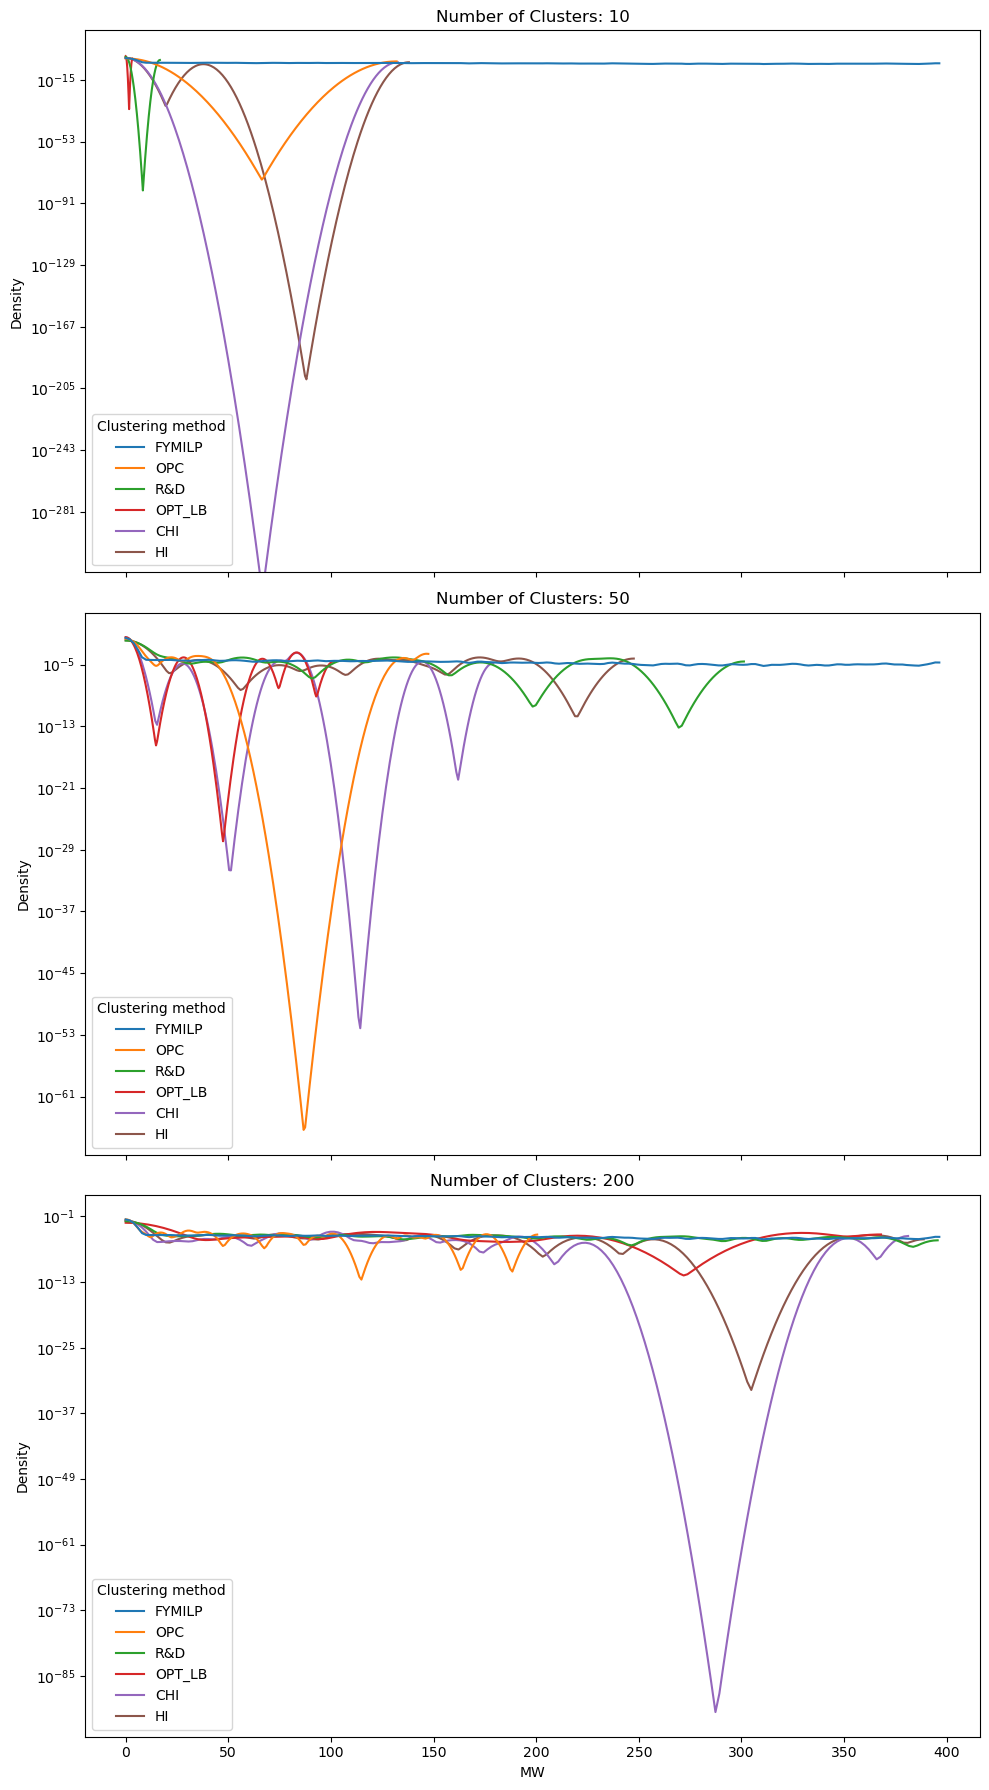

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Example data creation (Replace this with your actual DataFrame)
# all_utils = pd.DataFrame({
#     'Number of clusters': [...],
#     'Clustering method': [...],
#     'GWh': [...],
#     'Weight': [...]
# })

# Define the selected numbers of clusters and clustering methods
selected_nbs = [10, 50, 200]
selected_cms_w = ["OPC", "R&D", "CHI", "HI", "OPT_LB", "FYMILP"]

# Create subplots
fig, axes = plt.subplots(len(selected_nbs), 1, figsize=(10, 6 * len(selected_nbs)), sharex=True)

# Create a KDE plot for each selected number of clusters
for ax, nbs in zip(axes, selected_nbs):
    filter_w = all_curts["Number of clusters"].isin([nbs]) & all_curts["Clustering method"].isin(selected_cms_w)
    all_curts_sel = all_curts[filter_w]
    sns.kdeplot(data=all_curts_sel, x="MW", hue="Clustering method", cut=0, bw_adjust=0.5, weights=all_curts_sel["Weight"], ax=ax)
    ax.set_yscale('log')  # Set y-axis to logarithmic scale
    ax.set_title(f'Number of Clusters: {nbs}')

# Adjust layout
plt.tight_layout()
plt.show()


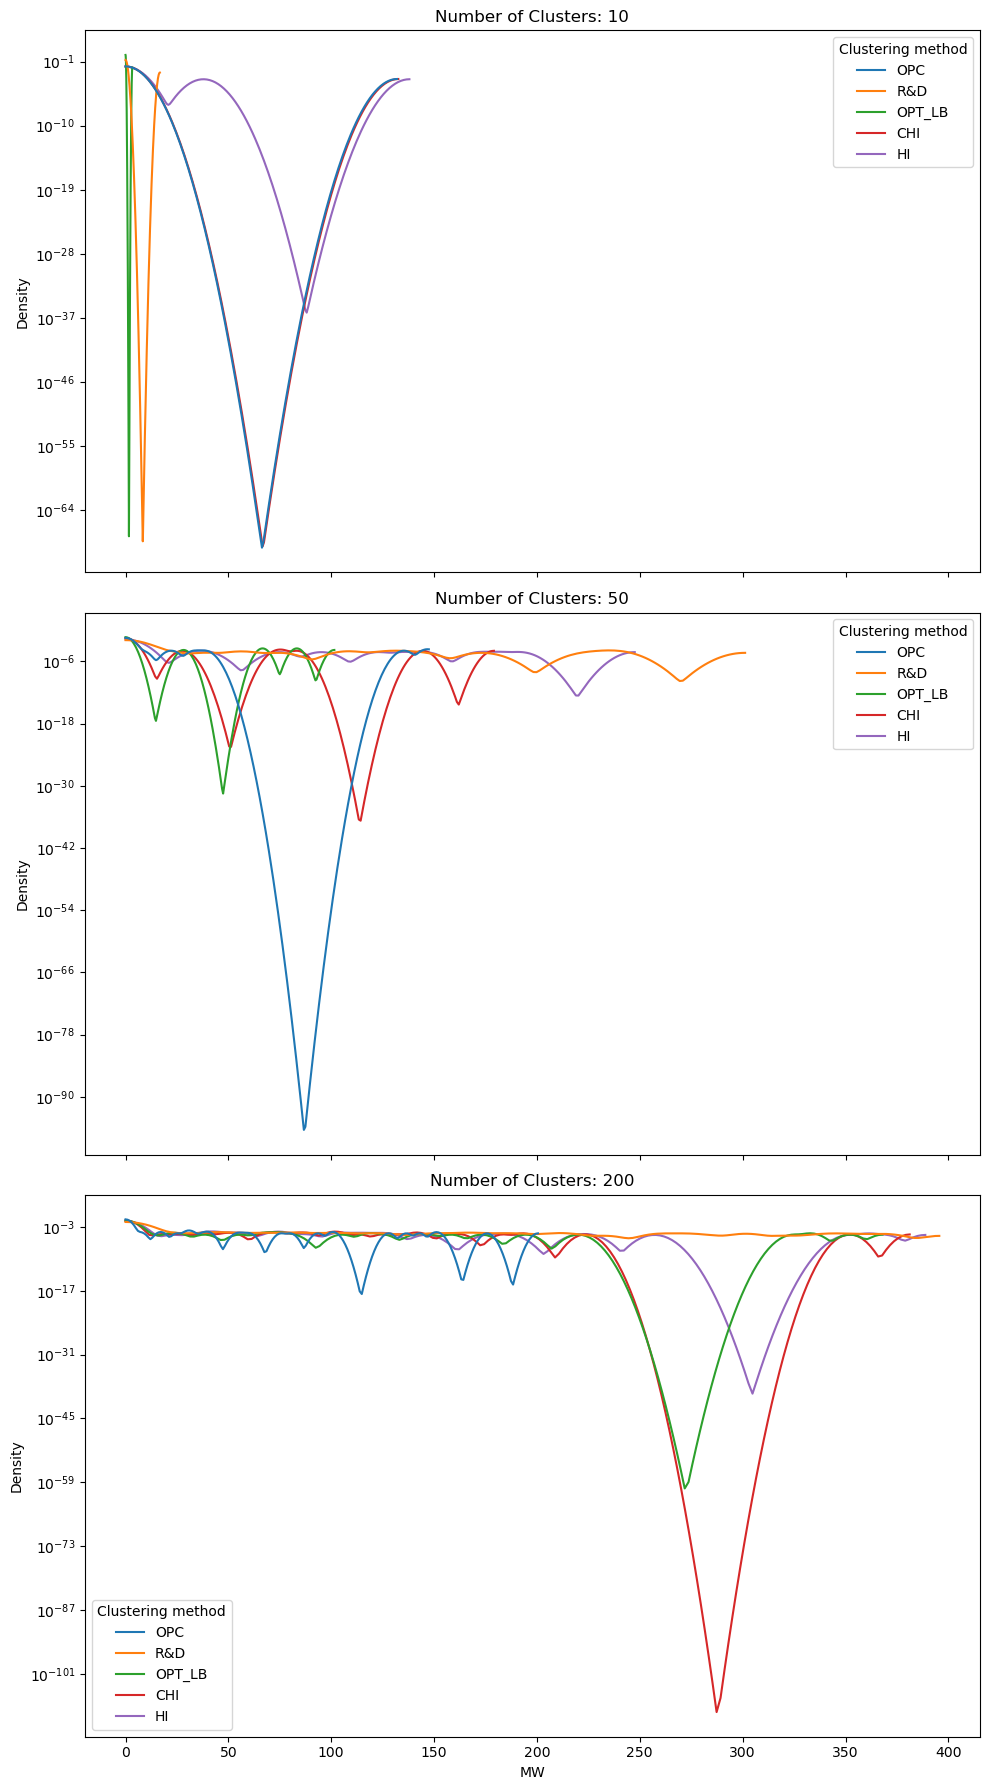

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Example data creation (Replace this with your actual DataFrame)
# all_utils = pd.DataFrame({
#     'Number of clusters': [...],
#     'Clustering method': [...],
#     'GWh': [...],
#     'Weight': [...]
# })

# Define the selected numbers of clusters and clustering methods
selected_nbs = [10, 50, 200]
selected_cms_w = ["OPC", "R&D", "CHI", "HI", "OPT_LB"]

# Create subplots
fig, axes = plt.subplots(len(selected_nbs), 1, figsize=(10, 6 * len(selected_nbs)), sharex=True)

# Create a KDE plot for each selected number of clusters
for ax, nbs in zip(axes, selected_nbs):
    filter_w = all_curts["Number of clusters"].isin([nbs]) & all_curts["Clustering method"].isin(selected_cms_w)
    all_curts_sel = all_curts[filter_w]
    sns.kdeplot(data=all_curts_sel, x="MW", hue="Clustering method", cut=0, bw_adjust=0.5, ax=ax)
    ax.set_yscale('log')  # Set y-axis to logarithmic scale
    ax.set_title(f'Number of Clusters: {nbs}')

# Adjust layout
plt.tight_layout()
plt.show()